In [1]:
%pip install keyring

Note: you may need to restart the kernel to use updated packages.


In [22]:
from treasury_ml_utils.snowflake_utils import SnowflakeConnector

snowflake_client = SnowflakeConnector("joshua.choy@transferwise.com")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://transferwise.okta-emea.com/app/snowflake/exk4istpb5gZUyV8u0i7/sso/saml?SAMLRequest=nZJPb%2BIwEMW%2FSuQ9J3a8dKEWUGVBLUilRRAqtTeTDGCR2KnHaeDbr8OfVffQHvYWOW%2Fm92be9O8OZRF8gEVl9IDEESMB6MzkSm8HZJXehz0SoJM6l4XRMCBHQHI37KMsi0oktdvpBbzXgC7wjTSK9seA1FYLI1Gh0LIEFC4Ty2T2KHjEhEQE6zyOXEpyVJ61c64SlDZNEzU%2FI2O3lDPGKLulXtVKfpBPiOp7RmWNM5kpriUHP9MXiJiyTovwCk%2BYXwp%2FK31ewXeU9VmEYpKm83D%2BvExJkFynGxmNdQl2CfZDZbBaPJ4NoHewSHm3w3sR1GEG2llZhHGE2jSbQu4hM2VVO9848l90AzktzFb5dU3HA1LtVT6bLB9m7%2FNJ8tApettqK5%2BX9WyddEc9tjCyMrt9DRN%2B%2B2pfk4wEL9dweRvuFLGGqW4jdf6J8V8hi0POU8bFDRecRd7YGwnGPlKlpTtVXn17pxo3YBuFEJm9kyGUIE82ZVXRvxNQOOw7Cl21vtm%2BrY4vvZqpLkU0tM2OnM9HnKzY4X8spU8%2FN7gc45PPZzqem0Jlx%2BDe2FK6r%2BOLo%2Fj0ovJwc5IKKKUqkjy3gOhjLArTjCxI52%2Fe2RoIHZ6p%2F179

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [24]:
# time frame

t = "2025-11-01 00:00:00"
t1 = "2025-12-31 00:00:00"

In [ ]:
# getting exposure data 
# test data

event_df = snowflake_client.fetch(f"""
SELECT TO_TIMESTAMP(HOUR_TS) AS HOUR_TS,
       CCY,
       EVENT_TYPE,
       EXPOSURE_DIRECTION,
       EXPOSURE_AMOUNT,
       n_events,
       n_large_flows,
FROM ANALYTICS_DB.RPT_TREASURY.EXPOSURE_EVENTS_HOURLY
WHERE HOUR_TS >= '{t}'
  AND HOUR_TS <= '{t1}'
  AND CCY IN ('USD',
              'GBP',
              'EUR',
              'AUD',
              'NZD',
              'CNY',
              'IDR',
              'INR',
              'THB',
              'MYR',
              'PHP',
              'KRW')
ORDER BY hour_ts
LIMIT 500000
""")

event_df.head()

,hour_ts,ccy,event_type,exposure_direction,exposure_amount,n_events,n_large_flows
0,2025-11-01,USD,TransferFeeCreditEvent,negative,-3.70,1,0
1,2025-11-01,THB,RollbackFixedRatePromisedEvent,positive,1391304.46,96,0
2,2025-11-01,GBP,RollbackFixedRatePromisedEvent,positive,406981.60,71,1
3,2025-11-01,NZD,PlasticInterchangeRevenueEvent,positive,39.74,45,0
4,2025-11-01,AUD,RollbackFixedRatePromisedEvent,negative,-321888.59,293,0


In [37]:
# joining query on rates and exposure

event_df = snowflake_client.fetch(f"""
SELECT 
    -- From the Exposure Table
    exp.HOUR_TS,
    exp.CCY,
    exp.EVENT_TYPE,
    exp.SUM_EXPOSURE_AMOUNT,
    exp.EXPOSURE_DIRECTION,
    exp.ACCOUNT_TYPE,
    
    -- From the Rates Table
    rates.CCY_PAIR,
    (rates.BID_OUTRIGHT + rates.OFFER_OUTRIGHT) / 2 AS RATE_MID

FROM 
    ANALYTICS_DB.RPT_TREASURY.WEEKEND_FEATURES_EXPOSURE_EVENTS_HOURLY AS exp

LEFT JOIN 
    ANALYTICS_DB.RPT_TREASURY.INT_ASSET_PRICING__FX_QUOTE_SNAPSHOT_HOURLY AS rates
    -- 1. Match on Time
    ON exp.HOUR_TS = rates.TIMESTAMP
    -- 2. Match on Currency (handling both pair formats)
    AND (
        rates.CCY_PAIR = exp.CCY || 'USD'  -- Matches GBPUSD, EURUSD, etc.
        OR 
        rates.CCY_PAIR = 'USD' || exp.CCY  -- Matches USDJPY, USDCAD, etc.
    )

WHERE 
    exp.HOUR_TS >= '2026-01-01 00:00:00'
    -- Filters from your Python screenshot to ensure clean rate data
    AND rates.TENOR_CODE = 'SP'
    AND rates.INSTRUMENT_TYPE = 'FXSpot'
    AND rates.PROVIDER = 'BLOOMBERG'
    AND CCY IN ('USD', 'GBP', 'EUR', 'AUD', 'NZD', 'CNY', 'IDR','INR', 'THB', 'MYR', 'PHP', 'KRW')
    
ORDER BY 
    exp.HOUR_TS;
""")

event_df.head()

,hour_ts,ccy,event_type,sum_exposure_amount,exposure_direction,account_type,ccy_pair,rate_mid
0,2026-01-01,EUR,RollbackFixedRateGuaranteedEvent,41450.69,positive,CUSTOMER,EURUSD,1.17445
1,2026-01-01,AUD,FixedRateGuaranteedEvent,114593.89,positive,CUSTOMER,AUDUSD,0.66755
2,2026-01-01,GBP,PayoutStoppedEvent,14729.51,positive,BORDERLESS,GBPUSD,1.34730
3,2026-01-01,MYR,FixedTransferMarkReceivedEvent,652932.78,positive,CUSTOMER,USDMYR,4.06025
4,2026-01-01,AUD,FixedTransferMarkReceivedEvent,-3028217.92,negative,CUSTOMER,AUDUSD,0.66755


In [38]:
# removing MarketOrder and InternalTransfer events

cleaned_df = event_df[~event_df['event_type'].str.contains('MarketOrder', 'InternalTransfer')]
cleaned_df

,hour_ts,ccy,event_type,sum_exposure_amount,exposure_direction,account_type,ccy_pair,rate_mid
0,2026-01-01,EUR,RollbackFixedRateGuaranteedEvent,41450.69,positive,CUSTOMER,EURUSD,1.17445
1,2026-01-01,AUD,FixedRateGuaranteedEvent,114593.89,positive,CUSTOMER,AUDUSD,0.66755
2,2026-01-01,GBP,PayoutStoppedEvent,14729.51,positive,BORDERLESS,GBPUSD,1.34730
3,2026-01-01,MYR,FixedTransferMarkReceivedEvent,652932.78,positive,CUSTOMER,USDMYR,4.06025
4,2026-01-01,AUD,FixedTransferMarkReceivedEvent,-3028217.92,negative,CUSTOMER,AUDUSD,0.66755
...,...,...,...,...,...,...,...,...
308602,2026-01-22,EUR,RollbackPlasticTransactionCreatedEvent,-3256.29,negative,BORDERLESS,USDEUR,0.85670
308603,2026-01-22,IDR,PayoutRestartedEvent,931330.00,positive,CUSTOMER,USDIDR,16935.00000
308604,2026-01-22,KRW,RollbackFixedRateGuaranteedEvent,10180000.00,positive,CUSTOMER,USDKRW,1465.85000
308605,2026-01-22,THB,RollbackFixedRateGuaranteedEvent,-36060.28,negative,CUSTOMER,USDTHB,31.30250


In [39]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305381 entries, 0 to 308606
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   hour_ts              305381 non-null  datetime64[ns]
 1   ccy                  305381 non-null  object        
 2   event_type           305381 non-null  object        
 3   sum_exposure_amount  305381 non-null  float64       
 4   exposure_direction   305381 non-null  object        
 5   account_type         305381 non-null  object        
 6   ccy_pair             305381 non-null  object        
 7   rate_mid             305381 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 21.0+ MB


In [41]:
# summation of ccy exposure over this time period

cleaned_df = cleaned_df.sort_values("hour_ts")
cleaned_df['cumulative_exposure'] = cleaned_df.groupby('ccy')['sum_exposure_amount'].cumsum()
cleaned_df.tail()

,hour_ts,ccy,event_type,sum_exposure_amount,exposure_direction,account_type,ccy_pair,rate_mid,cumulative_exposure
308604,2026-01-22,KRW,RollbackFixedRateGuaranteedEvent,10180000.00,positive,CUSTOMER,USDKRW,1465.85000,-1.525370e+11
308310,2026-01-22,EUR,BalanceConversionPnlEvent,3360.50,positive,BORDERLESS,EURUSD,1.16730,-5.877273e+08
308599,2026-01-22,MYR,BankTransactionPnlEvent,-711.30,negative,CUSTOMER,USDMYR,4.04800,-5.175308e+08
308455,2026-01-22,CNY,PayoutStoppedEvent,-25041.54,negative,CUSTOMER,USDCNY,6.96485,-5.334888e+08
308606,2026-01-22,IDR,PayoutStoppedEvent,-931330.00,negative,CUSTOMER,USDIDR,16935.00000,-3.262916e+12


<Axes: xlabel='hour_ts'>

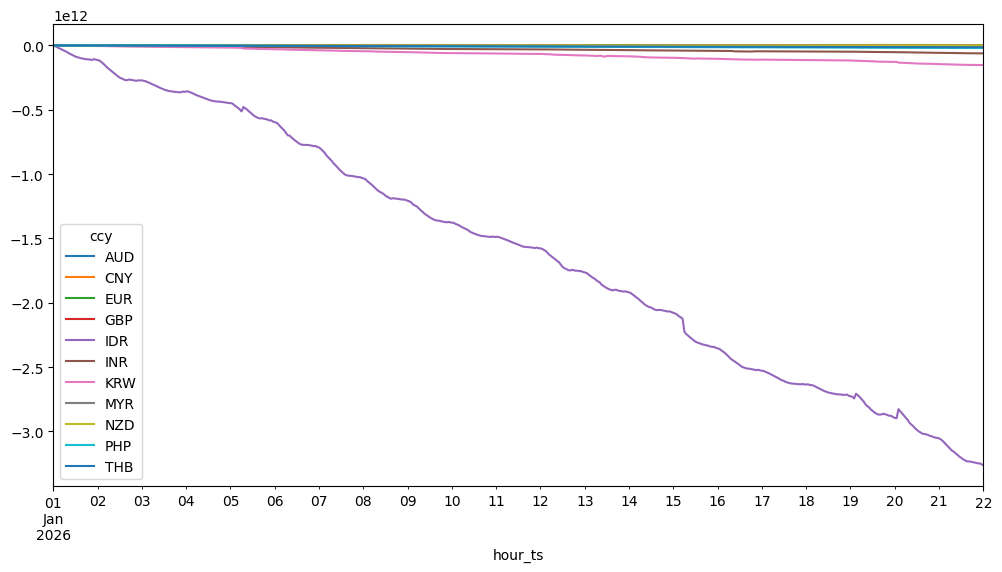

In [42]:
pivot_df = cleaned_df.pivot_table(index='hour_ts', columns='ccy', values='cumulative_exposure', aggfunc='last')
pivot_df.plot(figsize=(12,6))

In [ ]:
cleaned_df.columns
rates_df = cleaned_df[['hour_ts', 'ccy', 'rate_mid']]
rates_df['ccy)return'] = 

<Axes: >

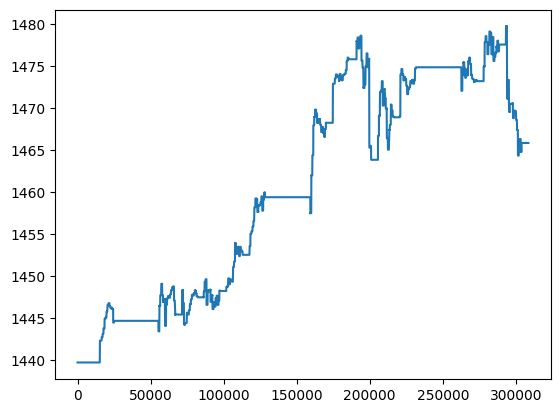

In [46]:
cleaned_df[cleaned_df['ccy_pair'] == 'USDKRW']['rate_mid'].plot()

## other queries


In [26]:
df = snowflake_client.fetch(f"""
        SELECT
            account.CCY AS ccy,
            TIME_SLICE(ledger.TIMESTAMP, 1, 'day', 'start') AS timestamp,
            SUM(ledger.AMOUNT) AS exposure_delta
        FROM RPT_TREASURY.LIQUIDITY_TRANSACTION_COMBINED AS ledger
        JOIN LIQUIDITY.ACCOUNT AS account
        ON ledger.ACCOUNTID = account.ID
        LEFT JOIN RPT_TREASURY.RAW_LIQUIDITY__SUBACCOUNT_MAPPING AS account_mapping
        ON ledger.SUBACCOUNTTYPE = account_mapping.SUBACCOUNT__TYPE
        WHERE TIMESTAMP > '{t}'
        AND TIMESTAMP <= '{t1}'
        AND CAUSINGEVENTTYPE NOT ILIKE '%MarketOrder%'
        AND account_mapping.SUBACCOUNT__GROUP != 'EQUITY'
        GROUP BY 1, 2
    """)

df.head()

,ccy,timestamp,exposure_delta
0,SZL,2025-11-30,-1.845000e+03
1,INR,2025-12-30,-2.553077e+09
2,DOP,2025-12-30,-1.184807e+05
3,TOP,2025-12-30,4.615800e+02
4,CNY,2025-11-01,-2.148946e+07


In [63]:
# exogenous customer activity events 

exo_events = ['BalanceInstantConversionEvent', 'BalanceReserveConversionEvent', 'FixedTransferMarkReceivedEvent', 'FixedTransferRollbackReceivedEvent', 'FixedRatePromisedEvent', 
              'RollbackFixedRatePromisedEvent', 'PlasticTransactionEvent']
ccy = ['BRL', 'INR', 'IDR', 'PHP', 'THB', 'CNY', 'KRW', 'VND']

exo_df = event_df[event_df['event_type'].isin(exo_events) & event_df['ccy'].isin(ccy)]
exo_df


,hour_ts,ccy,account_type,event_type,exposure_direction,sum_exposure_amount
16,2025-11-01 00:00:00,THB,CUSTOMER,FixedTransferMarkReceivedEvent,negative,-2.589068e+07
41,2025-11-01 00:00:00,PHP,CUSTOMER,RollbackFixedRatePromisedEvent,positive,1.925962e+07
48,2025-11-01 00:00:00,PHP,BORDERLESS,BalanceInstantConversionEvent,positive,4.432008e+05
80,2025-11-01 00:00:00,BRL,BORDERLESS,BalanceInstantConversionEvent,positive,1.090274e+06
83,2025-11-01 00:00:00,IDR,CUSTOMER,RollbackFixedRatePromisedEvent,negative,-7.625348e+07
...,...,...,...,...,...,...
4934,2025-11-01 03:00:00,THB,CUSTOMER,FixedRatePromisedEvent,positive,6.641730e+03
4944,2025-11-01 03:00:00,PHP,BORDERLESS,BalanceInstantConversionEvent,negative,-3.583626e+06
4967,2025-11-01 03:00:00,BRL,BORDERLESS,BalanceReserveConversionEvent,negative,-5.345959e+04
4991,2025-11-01 03:00:00,THB,CUSTOMER,RollbackFixedRatePromisedEvent,positive,1.126574e+06


In [10]:
# exposure delta

delta = snowflake_client.fetch(f"""

        SELECT
            account.CCY AS ccy,
            TIME_SLICE(ledger.TIMESTAMP, 1, 'day', 'start') AS timestamp,
            SUM(ledger.AMOUNT) AS exposure_delta
        FROM RPT_TREASURY.LIQUIDITY_TRANSACTION_COMBINED AS ledger
        JOIN LIQUIDITY.ACCOUNT AS account
        ON ledger.ACCOUNTID = account.ID
        LEFT JOIN RPT_TREASURY.RAW_LIQUIDITY__SUBACCOUNT_MAPPING AS account_mapping
        ON ledger.SUBACCOUNTTYPE = account_mapping.SUBACCOUNT__TYPE
        WHERE TIMESTAMP > '{t}'
        AND TIMESTAMP <= '{t1}'
        AND CAUSINGEVENTTYPE NOT ILIKE '%MarketOrder%'
        AND account_mapping.SUBACCOUNT__GROUP != 'EQUITY'
        GROUP BY 1, 2
    """)

delta.head()

,ccy,timestamp,exposure_delta
0,SZL,2025-11-30,-1845.00
1,USD,2025-11-02,62428858.44
2,ALL,2025-11-02,-455533.93
3,NOK,2025-11-02,1463536.40
4,RSD,2025-11-02,-2022890.06


In [32]:
delta["timestamp"] = pd.to_datetime(delta["timestamp"])
delta_df = delta.pivot(index="timestamp", columns="ccy", values="exposure_delta")
delta_df.sort_values("timestamp")

ccy,AED,AFN,ALL,AMD,AOA,ARS,AUD,AWG,AZN,BAM,...,VUV,WST,XAF,XCD,XCG,XOF,XPF,YER,ZAR,ZMW
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-11-01,-24647656.27,NaN,-236740.68,-7913644.31,396520.16,-1.476135e+08,44906421.77,40.00,-27717.73,-36468.54,...,-484598.0,-3835.56,-415203.0,-6235.05,314.09,-3040039.0,1001464.0,NaN,-3.153287e+07,-28949.24
2025-11-02,-29354554.43,NaN,-455533.93,-7098156.91,487011.47,1.198378e+06,36094557.14,0.00,-23727.23,16880.89,...,-696496.0,-3613.45,-578444.0,-6038.17,152.59,-1329235.0,-1145079.0,NaN,-2.482965e+07,100512.31
2025-11-03,-78855664.79,NaN,1463065.94,14844199.97,-1664711.03,-1.976358e+08,49054115.73,0.00,55185.18,27623.23,...,1105621.0,13332.96,-380485.0,-21612.25,-382.92,2988332.0,1053317.0,NaN,-1.118966e+08,-48778.74
2025-11-04,-76385752.25,NaN,-207477.63,1559902.10,1898338.56,9.380150e+07,2659018.38,0.00,6421.79,-5174.79,...,70383.0,2194.03,-1771544.0,34498.73,518.25,1251984.0,1160806.0,NaN,-4.349459e+07,34296.79
2025-11-05,-87805913.84,NaN,199810.37,107035.52,-688553.66,-1.863792e+06,17287768.84,-182.45,-903.81,6066.98,...,63119.0,-4546.94,421382.0,-12149.93,729.44,-1512711.0,-2289459.0,NaN,-7.792714e+07,-80104.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-27,-24303992.86,NaN,-249734.87,-6765965.75,-978120.89,-1.957676e+07,49571687.87,-559.25,-53122.56,-30569.21,...,-2024442.0,-3411.32,1942792.0,-6601.65,271.71,-960006.0,-3027752.0,-1188.32,-2.159400e+07,-148481.11
2025-12-28,-24211401.31,NaN,-425801.70,-7963240.07,2141635.30,-3.843587e+08,39882761.67,720.78,-13814.44,7632.09,...,-1505740.0,-20533.09,-65811.0,2489.78,698.97,-1865511.0,-2497458.0,1188.32,-2.545585e+07,124910.31
2025-12-29,-94151268.49,NaN,1122064.66,16122214.13,246313.03,-3.035784e+07,28767177.96,14.10,74514.19,12466.55,...,7475460.0,15002.38,2248865.0,-21343.65,-240.28,1218329.0,5830231.0,NaN,-8.241392e+07,-176100.01


In [23]:
delta.loc[delta['timestamp']=="2025-11-30"]

,ccy,timestamp,exposure_delta
0,SZL,2025-11-30,-1.845000e+03
52,KZT,2025-11-30,3.770309e+06
53,GNF,2025-11-30,-1.014000e+05
92,CHF,2025-11-30,6.137366e+06
93,HKD,2025-11-30,9.044863e+06
...,...,...,...
7939,NZD,2025-11-30,1.432926e+07
7940,VND,2025-11-30,-7.802826e+10
7941,NIO,2025-11-30,1.362131e+05
7942,OMR,2025-11-30,-1.459620e+03


In [ ]:
# getting ccy data

df = snowflake_client.fetch(f"""
    SELECT *, ((BID_OUTRIGHT+OFFER_OUTRIGHT)/2) as mid
    FROM RPT_TREASURY.INT_ASSET_PRICING__FX_QUOTE_SNAPSHOT_HOURLY
    WHERE CCY_PAIR IN ('USDPHP', 'EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'NZDUSD','USDCAD', 'USDCNH', 'USDSGD')
    AND TENOR_CODE = 'SP'
    AND INSTRUMENT_TYPE = 'FXSpot'
    AND PROVIDER = 'BLOOMBERG'
    AND TIMESTAMP BETWEEN '{t}' AND '{t1}'
""")
ccy_df = df.pivot(index='timestamp', columns='ccy_pair', values='mid')
ccy_df.head()

ccy_pair,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCNH,USDJPY,USDPHP,USDSGD
timestamp,,,,,,,,,
2026-01-11 00:00:00,0.6687,1.1636,1.3404,0.57315,1.39135,6.97595,157.89,59.2565,1.28745
2026-01-11 01:00:00,0.6687,1.1636,1.3404,0.57315,1.39135,6.97595,157.89,59.2565,1.28745
2026-01-11 02:00:00,0.6687,1.1636,1.3404,0.57315,1.39135,6.97595,157.89,59.2565,1.28745
2026-01-11 03:00:00,0.6687,1.1636,1.3404,0.57315,1.39135,6.97595,157.89,59.2565,1.28745
2026-01-11 04:00:00,0.6687,1.1636,1.3404,0.57315,1.39135,6.97595,157.89,59.2565,1.28745
